# Demo


**Author:** *Wong, Yat Chun*

**Date:** Jun 17, 2019



## 2. Source of Data

## 2.1 Xinwenlianbo Data

I extract the text data for Xinwenlianbo from 2013-01-01 to 2018-12-31. Here is an example:

In [1]:
import pandas as pd
import numpy as np

In [2]:
xwlbText = pd.read_csv('news_clean.csv')
xwlbText[['date', 'title', 'content']].head()

,date,title,content
0,2013-01-01,经济温和回升态势基本确立,今天，中国物流与采购联合会公布的2012年12月份制造业采购经理指数为50.6%，同上月持平...
1,2013-01-01,世界各地喜迎2013年,在2012年和2013年的更替之际，世界多地都举办了辞旧迎新活动。人们在这一刻互致祝福，对2...
2,2013-01-01,大庆油田实现连续十年原油稳产,截至2012年12月31日，大庆油田全年生产原油4000万吨、天然气33亿立方米。大庆油田连...
3,2013-01-01,【央视新年述评之二】中国梦：共享明天丰盈民生,今天是元旦，2013年第一个小长假开始了，您打算跟谁一起过节呢？就在几天前，全国人大常委会表...
4,2013-01-01,元旦一批新法新规开始实施,随着2013年的到来，我国一批与百姓生活密切相关的新法新规也开始正式实施。新修改刑诉法明确非...


## 2.2. Market Data

In [3]:
pd.read_csv('stock/000001SZ.csv')[['trade_date','close','vol']].head()

,trade_date,close,vol
0,20181228,9.38,576604.00
1,20181227,9.28,624593.27
2,20181226,9.30,421140.60
3,20181225,9.34,586615.45
4,20181224,9.42,509117.67


## 2.3. Company Keywords

In [4]:
pd.read_csv('company_description.csv').iloc[:,:3].head()

,code,name,description
0,000001SZ,平安银行,(一)吸收公众存款;(二)发放短期、中期和长期贷款;(三)办理国内外结算;(四)办理票据承兑...
1,000002SZ,万科,房地产开发;兴办实业(具体项目另行申报);国内商业、物资供销业(不含专营、专控、专卖商品);...
2,000333SZ,美的集团,生产经营家用电器、电机及其零部件;中央空调、采暖设备、通风设备、热泵设备、照明设备、燃气设备...
3,000725SZ,京东方,制造电子产品、通信设备、机械电器设备、五金交电、建筑材料、纸制品、工业气体、工具模具、蒸汽热...
4,000776SZ,广发证券,证券经纪;证券投资咨询;与证券交易、证券投资活动有关的财务顾问;证券承销与保荐;证券自营;证...


In [5]:
pd.read_csv('company_description.csv').iloc[:,[1,3]].head()

,name,keywords
0,平安银行,平安银行;存款;贷款;结算;票据;承兑;贴现;发行;金融;债券;承销;同业拆借;拆借;外汇;...
1,万科,万科;房地产;开发;实业;商业;供销业;进出口;业务;进出口业务
2,美的集团,美的集团;家用电器;电器;电机;中央空调;空调;采暖设备;通风设备;热泵设备;照明设备;燃气...
3,京东方,京东方;电子产品;通信设备;机械电器;五金;交电;五金交电;建筑材料;纸制品;工业气体;工具...
4,广发证券,广发证券;证券;证券经纪;证券投资;证券;投资;证券交易;交易;财务顾问;证券承销;承销;证...


## 3. Feature Engineering


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
from datetime import datetime

from ast import literal_eval

from scipy.cluster import hierarchy
from scipy.spatial import distance

from sklearn.base import clone
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score,mean_absolute_error

import glob, os    

target = 'fut_lag2_return_10'


i = "stock/000002SZ.csv"
stockCode = i[-12:-4]

    

stock1 = pd.read_csv(i)
stock1 = stock1[['trade_date','close','vol']]
stock1['trade_date'] = stock1['trade_date'].astype('str').apply(lambda x: datetime.strptime(x, "%Y%m%d"))
stock1 = stock1.set_index('trade_date')
stock1 = stock1.sort_index()
stock1 = stock1.fillna(method='ffill')



In [7]:
sent = pd.read_csv('news_baidu_sentiment.csv')

### 3.1.2. Keywords

In [8]:
kw = pd.read_csv('news_sent_kw_tag.csv')

The keywords for the above text is:

### 3.1.3. Tags

In [9]:
print(kw.lv1_tag.unique())

['财经' '音乐' '社会' '旅游' '国际' '时事' '科技' '汽车' '体育' '娱乐' '教育' '军事' '综合' '文化'
 '健康养生' '母婴育儿' '美食' '历史' '动漫' '家居' '时尚' '情感' '星座运势' '宠物' '游戏']


In [10]:
### News Feature Matrix

news = pd.read_csv('dummy_matrix.csv').drop('Unnamed: 0', axis =1)
news['date'] =  pd.to_datetime(news['date'], format='%Y-%m-%d')

# The keywords of news
news_keywords = pd.read_csv('news_sent_kw_tag.csv')[['date', 'keywords']]

# The keywords of the companys
stock_keywords = pd.read_csv('stock_keywords.csv')
stock_keywords['keywords'] = stock_keywords['keywords'].apply(literal_eval)
    # should specify which one
keyword1 = stock_keywords[stock_keywords['code'] == stockCode ]['keywords'].iloc[0]

# Find those relevant news for this compnay

news_keywords['relevant'] = news_keywords['keywords'].apply(lambda x: any([word in x for word in keyword1]))

### Relevant News
test = news.iloc[news_keywords[news_keywords['relevant']].index]
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')

### Summarise the News on that date
groupbyNews = test.groupby('date').agg({'lv1_tag_国际': 'sum',
 'lv1_tag_时事': 'sum',
 'lv1_tag_社会': 'sum',
 'lv1_tag_财经': 'sum',
 'sentiment_pos': 'mean',
 'dayofweek_1': 'mean',
 'dayofweek_2': 'mean',
 'dayofweek_3': 'mean',
 'dayofweek_4': 'mean',
 'dayofweek_5': 'mean',
 'dayofweek_6': 'mean',
 'quarter_2': 'mean',
 'quarter_3': 'mean',
 'quarter_4': 'mean',
 'month_2': 'mean',
 'month_3': 'mean',
 'month_4': 'mean',
 'month_5': 'mean',
 'month_6': 'mean',
 'month_7': 'mean',
 'month_8': 'mean',
 'month_9': 'mean',
 'month_10': 'mean',
 'month_11': 'mean',
 'month_12': 'mean',})

# The preditive feature matrix

feature1 = groupbyNews.join(stock1, how = 'inner')

### Standardize predictive features
std_scaler = StandardScaler()
features_scaled = std_scaler.fit_transform(feature1.dropna()) 

df = pd.DataFrame(features_scaled,index=feature1.dropna().index)
df.columns = feature1.dropna().columns


/home/Rex/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### 3.1.4. Information of Date

### 3.1.4. One-hot encoding and Removing rare features

## 3.2. Engineering features using market data

In [11]:
### Price Feature Matrix

# pct change
stock1['past_ret_1'] = stock1.close.pct_change(1) # past day's returns
stock1['past_ret_5'] = stock1.close.pct_change(5) # past week's returns
stock1['past_ret_10'] = stock1.close.pct_change(10) # past two weeks' returns
stock1['past_ret_20'] = stock1.close.pct_change(20) # past month's (approx) returns
stock1['logVol'] = stock1.vol.apply(np.log)
stock1['past_logVol_1'] = stock1.logVol.pct_change(1) # past day's change of log volume
stock1['past_logVol_5'] = stock1.logVol.pct_change(5) # past week's change of log volume
stock1['past_logVol_10'] = stock1.logVol.pct_change(10) # past two weeks' change of log volume
stock1['past_logVol_20'] = stock1.logVol.pct_change(20) # past month's change of log volume


# rolling mean or std
stock1['roll_Close_Mean_200'] = stock1['close'].rolling(window=200, min_periods=20).mean().shift(1)
stock1['roll_Close_Std_200'] = stock1['close'].rolling(window=200, min_periods=20).std().shift(1)
stock1['roll_LogVol_Mean_200'] = stock1['logVol'].rolling(window=200, min_periods=20).mean().shift(1)
stock1['roll_LogVol_Std_200'] = stock1['logVol'].rolling(window=200, min_periods=20).std().shift(1)


# z-score
stock1['zscore_price'] = (stock1['close'] - stock1['roll_Close_Mean_200'] ) / stock1['roll_Close_Std_200'] 
stock1['zscore_logVol'] = (stock1['logVol'] - stock1['roll_LogVol_Mean_200'] ) / stock1['roll_LogVol_Std_200'] 

# change sign
stock1['sign_LogVol_1'] = stock1['past_logVol_1'].apply(np.sign)
stock1['sign_Ret_1'] = stock1['past_ret_1'].apply(np.sign)


## 3.3. Defining Outcomes


**Assume enter the market at the close price of the next day:**

- `fut_lag1_return_1`: the return of holding the position after 1 trading day
- `fut_lag1_return_5`: the return of holding the position after 5 trading day
- `fut_lag1_return_10`: the return of holding the position after 10 trading day
- `fut_lag1_return_20`: the return of holding the position after 20 trading day

**Assume enter the market at the close price of the day after the the next day:**

- `fut_lag2_return_1`: the return of holding the position after 1 trading day
- `fut_lag2_return_5`: the return of holding the position after 5 trading day
- `fut_lag2_return_10`: the return of holding the position after 10 trading day
- `fut_lag2_return_20`: the return of holding the position after 20 trading day
        

In [12]:
### Outcome Feature

out_stock1 = pd.DataFrame(index = stock1.index)

### Pct Change

### Assume T+1 enter the market
out_stock1['fut_lag1_return_1'] = stock1.close.pct_change(-1).shift(-1) # next day's returns
out_stock1['fut_lag1_return_5'] = stock1.close.pct_change(-5).shift(-1) # next week's returns
out_stock1['fut_lag1_return_10'] = stock1.close.pct_change(-10).shift(-1) # next two weeks' returns
out_stock1['fut_lag1_return_20'] = stock1.close.pct_change(-20).shift(-1) # next month's (approx) returns
### Assume T+2 enter the market
out_stock1['fut_lag2_return_1'] = stock1.close.pct_change(-1).shift(-2) # next day's returns
out_stock1['fut_lag2_return_5'] = stock1.close.pct_change(-5).shift(-2) # next week's returns
out_stock1['fut_lag2_return_10'] = stock1.close.pct_change(-10).shift(-2) # next two weeks' returns
out_stock1['fut_lag2_return_20'] = stock1.close.pct_change(-20).shift(-2) # next month's (approx) returns

### Direction/sign

### Assume T+1 enter the market
out_stock1['fut_lag1_sign_1'] = np.sign(out_stock1['fut_lag1_return_1']) # next day's returns
out_stock1['fut_lag1_sign_5'] = np.sign(out_stock1['fut_lag1_return_5']) # next week's returns
out_stock1['fut_lag1_sign_10'] = np.sign(out_stock1['fut_lag1_return_10']) # next two weeks' returns
out_stock1['fut_lag1_sign_20'] = np.sign(out_stock1['fut_lag1_return_20']) # next month's (approx) returns
### Assume T+2 enter the market
out_stock1['fut_lag2_sign_1'] = np.sign(out_stock1['fut_lag2_return_1']) # next day's returns
out_stock1['fut_lag2_sign_5'] = np.sign(out_stock1['fut_lag2_return_5']) # next week's returns
out_stock1['fut_lag2_sign_10'] = np.sign(out_stock1['fut_lag2_return_10']) # next two weeks' returns
out_stock1['fut_lag2_sign_20'] = np.sign(out_stock1['fut_lag2_return_20']) # next month's (approx) returns

# dropna
outcome_scaled = out_stock1.dropna()

### Find the indices that both feature matrix and the outcome matrix share
index = df.index.intersection(outcome_scaled[target].index)

out = outcome_scaled[target].loc[index]
df = df.loc[index]


## 4. Modelling

### 4.1. Feature Selection

In [13]:
### Feature Selection

corr = df.corrwith(out)
selected_features = corr[abs(corr)>0.1].sort_values(ascending=False).index.tolist()
print("Features selected: ")
print(corr[abs(corr)>0.1])

Features selected: 
month_4     0.109681
month_11   -0.168934
close       0.127432
dtype: float64


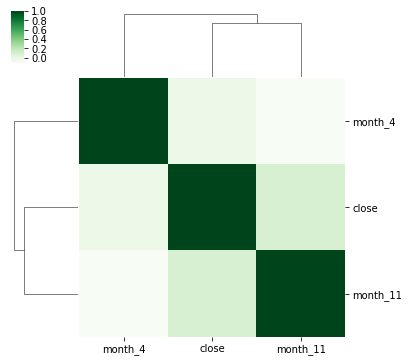

In [14]:
corr_matrix = df[selected_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

In [15]:
X = df[selected_features]
y = out

### 4.2. Walk-forward Analysis

In [16]:
def make_walkforward_model(features,outcome,algo=LinearRegression()):
    recalc_dates = features.resample('Y').mean().index.values[:-1]
    
    ## Train models
    models = pd.Series(index=recalc_dates)
    for date in recalc_dates:    
        X_train = features.loc[slice(None,date)]
        y_train = outcome.loc[slice(None,date)]
#         print(f'Train with data prior to: {date} ({y_train.count()} obs)')
        
        model = clone(algo)
        model.fit(X_train,y_train)
        models.loc[date] = model

    begin_dates = models.index
    end_dates = models.index[1:].append(pd.to_datetime(['2099-12-31']))

    ## Generate OUT OF SAMPLE walk-forward predictions
    predictions = pd.Series(index=features.index)
    for i,model in enumerate(models): #loop thru each models object in collection
#         print(f'Using model trained on {begin_dates[i]}, Predict from: {begin_dates[i]} to: {end_dates[i]}')
        X = features.loc[slice(begin_dates[i],end_dates[i])]
        p = pd.Series(model.predict(X),index=X.index)
        predictions.loc[X.index] = p
    
    return models,predictions

def prepare_Xy(X_raw,y_raw):
    ''' Utility function to drop any samples without both valid X and y values'''
    Xy = X_raw.join(y_raw).replace({np.inf:None,-np.inf:None}).dropna()
    X = Xy.iloc[:,:-1]
    y = Xy.iloc[:,-1]
    return X,y

### 4.3. Models 

In [17]:
linear_models,linear_preds = make_walkforward_model(X,y,algo=LinearRegression())
tree_models,tree_preds = make_walkforward_model(X,y,algo=ExtraTreesRegressor())


X_ens, y_ens = prepare_Xy(X_raw=pd.concat([linear_preds.rename('linear'),tree_preds.rename('tree')],
                                          axis=1),y_raw=y)

ensemble_models,ensemble_preds = make_walkforward_model(X_ens,y_ens,algo=LassoCV(positive=True))
ensemble_preds = ensemble_preds.rename('ensemble')



/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/Rex/anaconda3/lib/python3.6/site-packages/sklearn/

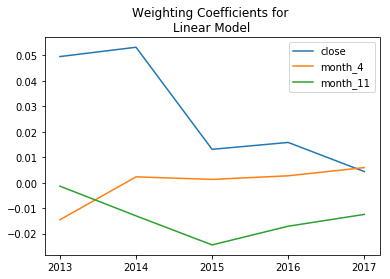

In [18]:
pd.DataFrame([model.coef_ for model in linear_models],
             columns=X.columns,index=linear_models.index).plot(title='Weighting Coefficients for \nLinear Model')

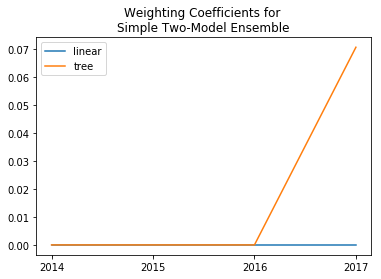

In [19]:
pd.DataFrame([model.coef_ for model in ensemble_models],
             columns=X_ens.columns,index=ensemble_models.index).plot(title='Weighting Coefficients for \nSimple Two-Model Ensemble')

### 4.4. Model Evaluation

In [20]:
def calc_scorecard(y_pred,y_true):
    
    def make_df(y_pred,y_true):
        y_pred.name = 'y_pred'
        y_true.name = 'y_true'

        df = pd.concat([y_pred,y_true],axis=1).dropna()

        df['sign_pred'] = df.y_pred.apply(np.sign)
        df['sign_true'] = df.y_true.apply(np.sign)
        df['is_correct'] = 0
        df.loc[df.sign_pred * df.sign_true > 0 ,'is_correct'] = 1 # only registers 1 when prediction was made AND it was correct
        df['is_incorrect'] = 0
        df.loc[df.sign_pred * df.sign_true < 0,'is_incorrect'] = 1 # only registers 1 when prediction was made AND it was wrong
        df['is_predicted'] = df.is_correct + df.is_incorrect
        df['result'] = df.sign_pred * df.y_true 
        return df
    
    df = make_df(y_pred,y_true)
    
    scorecard = pd.Series()
    
    # building block metrics
#     scorecard.loc['RSQ'] = r2_score(df.y_true,df.y_pred)
#     scorecard.loc['MAE'] = mean_absolute_error(df.y_true,df.y_pred)
    scorecard.loc['directional_accuracy'] = df.is_correct.sum()*1. / (df.is_predicted.sum()*1.)*100
    scorecard.loc['edge'] = df.result.mean()
#     scorecard.loc['noise'] = df.y_pred.diff().abs().mean()
    # derived metrics
    
    scorecard.loc['edge_long'] = df[df.sign_pred == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_short'] = df[df.sign_pred == -1].result.mean()  - df.y_true.mean()

    scorecard.loc['edge_win'] = df[df.is_correct == 1].result.mean()  - df.y_true.mean()
    scorecard.loc['edge_lose'] = df[df.is_incorrect == 1].result.mean()  - df.y_true.mean()

    
#     scorecard.loc['edge_to_noise'] = scorecard.loc['edge'] / scorecard.loc['noise']
#     scorecard.loc['edge_to_mae'] = scorecard.loc['edge'] / scorecard.loc['MAE']

    
    return scorecard    




Here is the result of *New China Life Insurance (601336.SH)*:

In [21]:
# calculate scores for each model
score_ens = calc_scorecard(y_pred=ensemble_preds,y_true=y_ens).rename('Ensemble')
score_linear = calc_scorecard(y_pred=linear_preds,y_true=y_ens).rename('Linear')
score_tree = calc_scorecard(y_pred=tree_preds,y_true=y_ens).rename('Tree')

scores = pd.concat([score_linear,score_tree,score_ens],axis=1)

print(scores)
# stat = scores.unstack().to_frame().sort_index(level=1).T
# stat.columns = stat.columns.map('_'.join)
# stat['sampleSize'] = len(df)
# stat['stock'] = stockCode

                         Linear       Tree   Ensemble
directional_accuracy  47.647059  47.399703  53.686200
edge                  -0.000400  -0.005194   0.003956
edge_long              0.002882  -0.001733        NaN
edge_short             0.030564   0.011490   0.007913
edge_win               0.071086   0.066659   0.066387
edge_lose             -0.050743  -0.055423  -0.059838


## 5. Result

In [22]:
fut11 = pd.read_csv('fut_lag1_return_1_result.csv')
fut11['scheme'] = 'fut_lag1_return_1'

fut15 = pd.read_csv('fut_lag1_return_5_result.csv')
fut15['scheme'] = 'fut_lag1_return_5'

fut110 = pd.read_csv('fut_lag1_return_10_result.csv')
fut110['scheme'] = 'fut_lag1_return_10'

fut120 = pd.read_csv('fut_lag1_return_20_result.csv')
fut120['scheme'] = 'fut_lag1_return_20'

fut21 = pd.read_csv('fut_lag2_return_1_result.csv')
fut21['scheme'] = 'fut_lag2_return_1'

fut25 = pd.read_csv('fut_lag2_return_5_result.csv')
fut25['scheme'] = 'fut_lag2_return_5'

fut210 = pd.read_csv('fut_lag2_return_10_result.csv')
fut210['scheme'] = 'fut_lag2_return_10'

fut220 = pd.read_csv('fut_lag2_return_20_result.csv')
fut220['scheme'] = 'fut_lag2_return_20'

result = pd.DataFrame()
result = result.append([fut11, fut15,fut110,fut120,fut21,fut25,fut210,fut220], ignore_index = True)

col = ['stock', 'scheme', 
 'Ensemble_directional_accuracy', 'Linear_directional_accuracy', 'Tree_directional_accuracy',
 'Ensemble_edge', 'Linear_edge', 'Tree_edge', ]
#  'Ensemble_edge_long','Ensemble_edge_short',
#  'Linear_edge_long', 'Linear_edge_short', 
#  'Tree_edge_long', 'Tree_edge_short',
#  'Ensemble_edge_win','Ensemble_edge_lose',
#  'Linear_edge_win', 'Linear_edge_lose',
#  'Tree_edge_win', 'Tree_edge_lose']

result = result[col]

### 5.1 Sort by Ensemble directional accuracy

In [23]:
result.sort_values('Ensemble_directional_accuracy', ascending = False).head(10).style.hide_index()

stock,scheme,Ensemble_directional_accuracy,Linear_directional_accuracy,Tree_directional_accuracy,Ensemble_edge,Linear_edge,Tree_edge
000002SZ,fut_lag1_return_20,58.7571,55.4412,47.2059,0.0273933,0.0225188,-0.00529131
000002SZ,fut_lag2_return_20,57.6271,53.8123,51.173,0.0224225,0.0175089,0.00501927
601169SH,fut_lag1_return_10,56.9811,50.439,50.3415,-0.00125049,0.00791756,0.00433321
601169SH,fut_lag2_return_20,56.875,46.2585,49.9514,-0.00754086,0.00490632,-0.00224083
601169SH,fut_lag1_return_20,56.4456,46.8872,52.7237,-0.00784145,0.00576013,0.00444523
000002SZ,fut_lag1_return_10,56.2264,58.9706,48.6765,0.0187267,0.0225525,0.00370633
601169SH,fut_lag2_return_10,55.6533,49.5127,50.0975,-0.00023312,0.0058848,0.00361827
000002SZ,fut_lag2_return_10,55.1985,56.9118,49.4118,0.0157422,0.0167093,0.00236902
601601SH,fut_lag2_return_10,55.1451,54.8387,42.872,-0.00123683,0.0100241,-0.00702981
600036SH,fut_lag1_return_10,54.994,52.8746,52.8746,0.00463885,0.00217294,0.00217294


### 5.2. Sort by Linear directional accuracy:

In [24]:
result.sort_values('Linear_directional_accuracy', ascending = False).head(10).style.hide_index()

stock,scheme,Ensemble_directional_accuracy,Linear_directional_accuracy,Tree_directional_accuracy,Ensemble_edge,Linear_edge,Tree_edge
000002SZ,fut_lag1_return_10,56.2264,58.9706,48.6765,0.0187267,0.0225525,0.00370633
601336SH,fut_lag1_return_5,48.1781,57.4153,52.7542,-0.0017896,0.0101318,0.000803236
601166SH,fut_lag1_return_20,50.358,56.9691,48.6436,-0.00347077,0.013585,-0.00282665
000776SZ,fut_lag1_return_20,44.186,56.9457,53.7259,-0.0238422,0.0253844,0.023521
000002SZ,fut_lag2_return_10,55.1985,56.9118,49.4118,0.0157422,0.0167093,0.00236902
601166SH,fut_lag2_return_20,50.2387,56.8756,45.8372,-0.00383376,0.0133584,-0.00231464
600016SH,fut_lag1_return_10,53.6058,56.3089,53.6723,0.00299443,0.00835923,0.000142403
600016SH,fut_lag2_return_10,53.6703,56.1321,52.5472,0.00751193,0.00997903,-0.00478899
000776SZ,fut_lag2_return_20,44.3023,55.9338,55.1978,-0.0244952,0.0221132,0.0258508
601166SH,fut_lag1_return_10,51.3189,55.8796,57.2907,-0.002264,0.00826389,0.00796842


### 5.3. Sort by Tree directional accuracy:

In [25]:
result.sort_values('Tree_directional_accuracy', ascending = False).head(10).style.hide_index()

stock,scheme,Ensemble_directional_accuracy,Linear_directional_accuracy,Tree_directional_accuracy,Ensemble_edge,Linear_edge,Tree_edge
601166SH,fut_lag2_return_10,52.3981,55.5033,58.8899,4.7678e-05,0.00817162,0.0128073
601998SH,fut_lag1_return_10,47.4002,48.3444,58.6566,-0.00484632,-0.00209871,0.0119576
000001SZ,fut_lag2_return_20,45.292,53.9757,57.9981,-0.00589108,0.0122787,0.0148484
601818SH,fut_lag1_return_20,48.7242,50.5243,57.96,-0.00700283,0.00959395,0.0164326
601688SH,fut_lag2_return_20,50.2304,49.2701,57.938,-0.0153738,0.015147,0.0199436
000001SZ,fut_lag2_return_10,54.1219,51.5009,57.6923,0.00988322,0.00467025,0.0123358
601166SH,fut_lag1_return_10,51.3189,55.8796,57.2907,-0.002264,0.00826389,0.00796842
000001SZ,fut_lag1_return_10,50.2387,51.6886,57.2233,0.00481157,0.00600707,0.0113231
601998SH,fut_lag2_return_10,47.4638,49.3862,55.9018,-0.0047861,-0.000841246,0.0116199
600000SH,fut_lag2_return_5,52.2444,55.6202,55.6202,0.000881551,0.00514575,0.00514575


### 5.4. Sort by Ensemble Edge:

In [26]:
result.sort_values('Ensemble_edge', ascending = False).head(10).style.hide_index()

stock,scheme,Ensemble_directional_accuracy,Linear_directional_accuracy,Tree_directional_accuracy,Ensemble_edge,Linear_edge,Tree_edge
000002SZ,fut_lag1_return_20,58.7571,55.4412,47.2059,0.0273933,0.0225188,-0.00529131
000002SZ,fut_lag2_return_20,57.6271,53.8123,51.173,0.0224225,0.0175089,0.00501927
000002SZ,fut_lag1_return_10,56.2264,58.9706,48.6765,0.0187267,0.0225525,0.00370633
000002SZ,fut_lag2_return_10,55.1985,56.9118,49.4118,0.0157422,0.0167093,0.00236902
000001SZ,fut_lag2_return_10,54.1219,51.5009,57.6923,0.00988322,0.00467025,0.0123358
600036SH,fut_lag1_return_20,53.11,49.2495,50.0938,0.00843198,-0.00116855,-0.00312893
600016SH,fut_lag2_return_10,53.6703,56.1321,52.5472,0.00751193,0.00997903,-0.00478899
600016SH,fut_lag1_return_20,52.6379,55.0752,52.1617,0.00571708,0.0138637,0.00943282
000001SZ,fut_lag1_return_10,50.2387,51.6886,57.2233,0.00481157,0.00600707,0.0113231
600036SH,fut_lag2_return_10,54.5126,52.6365,52.6365,0.00470871,0.00232164,0.00232164


### 5.5. Sort by Linear edge:

In [27]:
result.sort_values('Linear_edge', ascending = False).head(10).style.hide_index()

stock,scheme,Ensemble_directional_accuracy,Linear_directional_accuracy,Tree_directional_accuracy,Ensemble_edge,Linear_edge,Tree_edge
000776SZ,fut_lag1_return_20,44.186,56.9457,53.7259,-0.0238422,0.0253844,0.023521
000002SZ,fut_lag1_return_10,56.2264,58.9706,48.6765,0.0187267,0.0225525,0.00370633
000002SZ,fut_lag1_return_20,58.7571,55.4412,47.2059,0.0273933,0.0225188,-0.00529131
000776SZ,fut_lag2_return_20,44.3023,55.9338,55.1978,-0.0244952,0.0221132,0.0258508
600030SH,fut_lag1_return_20,48.1914,54.9724,54.4199,-0.0197067,0.0194316,0.0103089
600030SH,fut_lag2_return_20,48.951,54.5538,52.4379,-0.0198596,0.0182845,0.00663936
000002SZ,fut_lag2_return_20,57.6271,53.8123,51.173,0.0224225,0.0175089,0.00501927
000002SZ,fut_lag2_return_10,55.1985,56.9118,49.4118,0.0157422,0.0167093,0.00236902
601688SH,fut_lag1_return_20,49.7696,48.7226,50.2737,-0.0151292,0.0158914,0.00246452
601688SH,fut_lag2_return_20,50.2304,49.2701,57.938,-0.0153738,0.015147,0.0199436


### 5.6. Sort by Tree edge:

In [28]:
result.sort_values('Tree_edge', ascending = False).head(10).style.hide_index()

stock,scheme,Ensemble_directional_accuracy,Linear_directional_accuracy,Tree_directional_accuracy,Ensemble_edge,Linear_edge,Tree_edge
000776SZ,fut_lag2_return_20,44.3023,55.9338,55.1978,-0.0244952,0.0221132,0.0258508
000776SZ,fut_lag1_return_20,44.186,56.9457,53.7259,-0.0238422,0.0253844,0.023521
601318SH,fut_lag2_return_20,39.6846,48.4974,46.5285,-0.0495172,-0.0390481,0.0219256
601688SH,fut_lag2_return_20,50.2304,49.2701,57.938,-0.0153738,0.015147,0.0199436
601818SH,fut_lag1_return_20,48.7242,50.5243,57.96,-0.00700283,0.00959395,0.0164326
000001SZ,fut_lag2_return_20,45.292,53.9757,57.9981,-0.00589108,0.0122787,0.0148484
601318SH,fut_lag1_return_10,48.8801,53.9979,49.0135,-0.0213584,-0.0148346,0.0130001
601166SH,fut_lag2_return_10,52.3981,55.5033,58.8899,4.7678e-05,0.00817162,0.0128073
601318SH,fut_lag1_return_20,42.2925,48.5981,46.4174,-0.0451265,-0.0400592,0.0124911
000001SZ,fut_lag2_return_10,54.1219,51.5009,57.6923,0.00988322,0.00467025,0.0123358


In [57]:
wanke = pd.read_csv('stock/000002SZ.csv')
wanke.head()

,Unnamed: 0,ts_code,trade_date,open,high,low,close,pre_close,change,pct_chg,vol,amount
0,0,000002.SZ,20181228,23.67,24.24,23.67,23.82,23.44,0.38,1.6212,322810.93,772703.701
1,1,000002.SZ,20181227,24.25,24.56,23.44,23.44,23.80,-0.36,-1.5126,352501.78,849242.338
2,2,000002.SZ,20181226,23.84,23.98,23.58,23.80,23.97,-0.17,-0.7092,221987.26,528530.965
3,3,000002.SZ,20181225,23.42,24.22,23.38,23.97,23.88,0.09,0.3769,426901.26,1016225.858
4,4,000002.SZ,20181224,23.92,24.08,23.33,23.88,24.25,-0.37,-1.5258,493219.42,1164770.722


In [58]:
col = ['trade_date','close','change','pct_chg']
wanke = wanke[col]
wanke['trade_date'] = wanke['trade_date'].astype('str').apply(lambda x: datetime.strptime(x, "%Y%m%d"))
wanke['pct_chg'] = wanke['pct_chg'].shift(1)
wanke['change'] = wanke['change'].shift(1)
wanke = wanke.set_index('trade_date').sort_index().fillna(method='ffill')
wanke.head()

,close,change,pct_chg
trade_date,,,
2011-01-04,8.80,0.03,0.34
2011-01-05,8.83,0.01,0.11
2011-01-06,8.84,0.05,0.57
2011-01-07,8.89,-0.15,-1.69
2011-01-10,8.74,0.29,3.32


In [59]:
# wanke = wanke.join(np.sign(ensemble_preds.shift(2)), how = 'left').fillna(0)
# start = ensemble_preds[~ensemble_preds.isna()].index[0]
# end = ensemble_preds[~ensemble_preds.isna()].index[-1]
# wanke = wanke.loc[start:end]

# wanke = wanke.join(np.sign(linear_preds.shift(2)), how = 'left').fillna(0)
# start = linear_preds[~linear_preds.isna()].index[0]
# end = linear_preds[~linear_preds.isna()].index[-1]
# wanke = wanke.loc[start:end]

wanke = wanke.join(np.sign(tree_preds.shift(2)), how = 'left').fillna(0)
start = tree_preds[~tree_preds.isna()].index[0]
end = tree_preds[~tree_preds.isna()].index[-1]
wanke = wanke.loc[start:end]


wanke['cum_pred'] = wanke['y_pred'].cumsum()
wanke['position'] = 0
# for i in range(len(wanke)):
#     if wanke['y_pred'].iloc[i] * wanke['position'].iloc[i-1] > 0:
#         wanke['position'].iloc[i] = wanke['position'].iloc[i-1] + wanke['y_pred'].iloc[i]
#     elif wanke['y_pred'].iloc[i] * wanke['position'].iloc[i-1] == 0:
#         if wanke['position'].iloc[i-1] == 0 and wanke['y_pred'].iloc[i] != 0:
#             wanke['position'].iloc[i] = wanke['y_pred'].iloc[i]
#         else:
#             wanke['position'].iloc[i] = wanke['position'].iloc[i-1] 
#     elif wanke['y_pred'].iloc[i] * wanke['position'].iloc[i-1] < 0:
#         wanke['position'].iloc[i] = 0
        
for i in range(len(wanke)):
    if wanke['y_pred'].iloc[i] > 0:
        wanke['position'].iloc[i] = wanke['position'].iloc[i-1] + 1
    elif wanke['y_pred'].iloc[i] == 0:
        wanke['position'].iloc[i] = wanke['y_pred'].iloc[i]
    elif wanke['y_pred'].iloc[i-1] < 0:
        wanke['position'].iloc[i] = 0

wanke['dollarReturn'] = wanke['position'] * wanke['change']
wanke['cumDollarReturn'] = wanke['dollarReturn'].cumsum()
wanke['pos_chg'] = wanke['position'].diff().fillna(0)
wanke['transaction'] = -wanke['pos_chg'] * wanke['close']
wanke

,close,change,pct_chg,y_pred,cum_pred,position,dollarReturn,cumDollarReturn,pos_chg,transaction
trade_date,,,,,,,,,,
2014-01-03,7.84,-0.36,-4.5900,0.0,0.0,0.0,-0.00,-0.00,0.0,-0.00
2014-01-06,7.48,-0.05,-0.6700,0.0,0.0,0.0,-0.00,-0.00,0.0,-0.00
2014-01-07,7.43,-0.01,-0.1300,1.0,1.0,1.0,-0.01,-0.01,1.0,-7.43
2014-01-08,7.42,0.04,0.5400,1.0,2.0,2.0,0.08,0.07,1.0,-7.42
2014-01-09,7.46,-0.08,-1.0700,0.0,2.0,0.0,-0.00,0.07,-2.0,14.92
2014-01-10,7.38,-0.14,-1.9000,1.0,3.0,1.0,-0.14,-0.07,1.0,-7.38
2014-01-13,7.24,-0.01,-0.1400,0.0,3.0,0.0,-0.00,-0.07,-1.0,7.24
2014-01-14,7.23,-0.06,-0.8300,0.0,3.0,0.0,-0.00,-0.07,0.0,-0.00
2014-01-15,7.17,0.02,0.2800,1.0,4.0,1.0,0.02,-0.05,1.0,-7.17


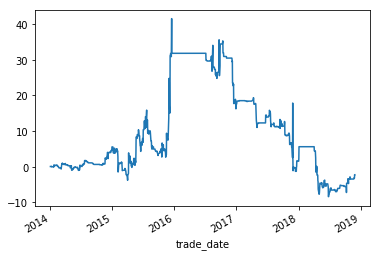

In [60]:
wanke['cumDollarReturn'].plot()

In [61]:
SSE50 = pd.read_csv('index/SSE50.csv')
col = ['trade_date','close','change','pct_chg']
SSE50 = SSE50[col]
SSE50['trade_date'] = SSE50['trade_date'].astype('str').apply(lambda x: datetime.strptime(x, "%Y%m%d"))
SSE50['pct_chg'] = SSE50['pct_chg'].shift(1)
SSE50['change'] = SSE50['change'].shift(1)
SSE50 = SSE50.set_index('trade_date').sort_index().fillna(method='ffill')
SSE50 = SSE50.loc[start:end]
SSE50['transaction_dollar'] = -wanke['transaction']
SSE50['fraction'] = SSE50['transaction_dollar'] / SSE50['close']
SSE50['position'] = SSE50['fraction'].cumsum()
SSE50['dollarReturn'] = SSE50['position'] * SSE50['change']
SSE50['cumDollarReturn'] = SSE50['dollarReturn'].cumsum()
SSE50

,close,change,pct_chg,transaction_dollar,fraction,position,dollarReturn,cumDollarReturn
trade_date,,,,,,,,
2014-01-03,1536.0670,-23.1370,-1.5062,0.00,0.000000,0.000000,-0.000000,-0.000000
2014-01-06,1512.9300,-2.2760,-0.1504,0.00,0.000000,0.000000,-0.000000,-0.000000
2014-01-07,1510.6540,4.6790,0.3097,7.43,0.004918,0.004918,0.023013,0.023013
2014-01-08,1515.3330,-11.4520,-0.7557,7.42,0.004897,0.009815,-0.112402,-0.089388
2014-01-09,1503.8810,-5.6130,-0.3732,-14.92,-0.009921,-0.000106,0.000595,-0.088793
2014-01-10,1498.2680,-3.6550,-0.2439,7.38,0.004926,0.004820,-0.017616,-0.106409
2014-01-13,1494.6130,4.6720,0.3126,-7.24,-0.004844,-0.000024,-0.000114,-0.106523
2014-01-14,1499.2850,-10.7760,-0.7187,0.00,0.000000,-0.000024,0.000263,-0.106261
2014-01-15,1488.5090,4.5850,0.3080,7.17,0.004817,0.004793,0.021974,-0.084287


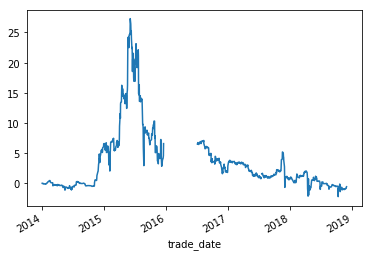

In [62]:
SSE50['cumDollarReturn'].plot()

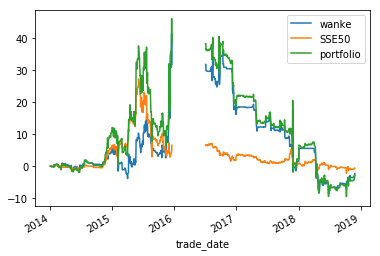

In [63]:
pd.DataFrame({"wanke":wanke['cumDollarReturn'], "SSE50":SSE50['cumDollarReturn'],"portfolio":wanke['cumDollarReturn'] + SSE50['cumDollarReturn']}).plot()

In [29]:
np.sign(linear_preds).cumsum()

2013-01-21      NaN
2013-01-22      NaN
2013-01-24      NaN
2013-01-25      NaN
2013-01-28      NaN
2013-01-30      NaN
2013-01-31      NaN
2013-02-05      NaN
2013-02-08      NaN
2013-02-19      NaN
2013-02-20      NaN
2013-02-21      NaN
2013-02-22      NaN
2013-02-26      NaN
2013-03-05      NaN
2013-03-07      NaN
2013-03-08      NaN
2013-03-12      NaN
2013-03-13      NaN
2013-03-21      NaN
2013-03-22      NaN
2013-03-25      NaN
2013-03-26      NaN
2013-03-27      NaN
2013-04-02      NaN
2013-04-09      NaN
2013-04-10      NaN
2013-04-11      NaN
2013-04-15      NaN
2013-04-18      NaN
              ...  
2018-09-25    485.0
2018-09-26    486.0
2018-09-27    487.0
2018-10-08    486.0
2018-10-09    485.0
2018-10-10    484.0
2018-10-11    483.0
2018-10-12    482.0
2018-10-17    481.0
2018-10-19    480.0
2018-10-22    479.0
2018-10-23    478.0
2018-10-29    477.0
2018-10-30    478.0
2018-10-31    479.0
2018-11-01    478.0
2018-11-02    477.0
2018-11-06    476.0
2018-11-07    475.0


In [64]:
wanke.loc[pd.to_datetime('2015-12-31'):pd.to_datetime('2016-12-31')]

,close,change,pct_chg,y_pred,cum_pred,position,dollarReturn,cumDollarReturn,pos_chg,transaction
trade_date,,,,,,,,,,
2016-07-04,21.99,-2.20,-10.00,0.0,229.0,0.0,-0.00,31.83,-4.0,87.96
2016-07-05,19.79,0.01,0.05,1.0,230.0,1.0,0.01,31.84,1.0,-19.79
2016-07-06,19.80,-0.98,-4.95,1.0,231.0,2.0,-1.96,29.88,1.0,-19.80
2016-07-07,18.82,-0.07,-0.37,0.0,231.0,0.0,-0.00,29.88,-2.0,37.64
2016-07-08,18.75,-0.48,-2.56,0.0,231.0,0.0,-0.00,29.88,0.0,-0.00
2016-07-11,18.27,-0.15,-0.82,1.0,232.0,1.0,-0.15,29.73,1.0,-18.27
2016-07-12,18.12,0.20,1.10,0.0,232.0,0.0,0.00,29.73,-1.0,18.12
2016-07-13,18.32,-0.36,-1.97,0.0,232.0,0.0,-0.00,29.73,0.0,-0.00
2016-07-14,17.96,-0.07,-0.39,1.0,233.0,1.0,-0.07,29.66,1.0,-17.96


In [65]:
SSE50.loc[pd.to_datetime('2015-12-31'):pd.to_datetime('2016-12-31')]

,close,change,pct_chg,transaction_dollar,fraction,position,dollarReturn,cumDollarReturn
trade_date,,,,,,,,
2015-12-31,2420.8008,-150.3399,-6.2103,NaN,NaN,NaN,NaN,NaN
2016-01-04,2270.4609,17.6518,0.7775,NaN,NaN,NaN,NaN,NaN
2016-01-05,2288.1127,29.5338,1.2907,NaN,NaN,NaN,NaN,NaN
2016-01-06,2317.6465,-137.0576,-5.9137,NaN,NaN,NaN,NaN,NaN
2016-01-07,2180.5889,39.0230,1.7896,NaN,NaN,NaN,NaN,NaN
2016-01-08,2219.6119,-99.3777,-4.4773,NaN,NaN,NaN,NaN,NaN
2016-01-11,2120.2342,11.1337,0.5251,NaN,NaN,NaN,NaN,NaN
2016-01-12,2131.3679,-25.8613,-1.2134,NaN,NaN,NaN,NaN,NaN
2016-01-13,2105.5066,26.5691,1.2619,NaN,NaN,NaN,NaN,NaN
